[View in Colaboratory](https://colab.research.google.com/github/saranyamandava/Lambda-School-DataScience/blob/master/Week8_Coding_Challenge_Association_Models_3.ipynb)

**Coding Challenge**

In this coding challenge, you will apply the concepts of Association Rule Learning

1) Utilize the Apriori Algorithm to uncover frequent itemsets 

2) Discover the strongest association rules that have high lift and high confidence

3) Create a Directed Graph to surface the association rules identified in Step 2 above

**Resources**:

- The Wikipedia articles for [association rule learning](https://en.wikipedia.org/wiki/Association_rule_learning) and the [Apriori algorithm](https://en.wikipedia.org/wiki/Apriori_algorithm) provide a good introduction and overview of the topic.
- The `mlxtend` package provides an [implementation of Apriori](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) ([source code](https://github.com/rasbt/mlxtend/blob/master/mlxtend/frequent_patterns/apriori.py)) - it is encouraged to read and understand the documentation and code, so you can be a savvy user of it.
- The `networkx` package has a [tutorial for drawing a directed graph](https://networkx.github.io/documentation/networkx-1.10/tutorial/index.html).


**Dataset: ** The data you will utilize is from the **UCI Machine Learning Repository** and represents transactional data from a UK retailer from 2010 through 2011. The data set represents sales to wholesalers so it is slightly different from data representing customer purchase patterns but is still a useful data set for the purposes of this exercise.

The data set can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx

**Guidance for coding challenge**:

1) Focus on the data for the following 2 countries: 1) **Germany** and 2) **Belgium**. Go through the 3 steps highlighted above for each of the 2 countries. This analysis will enable you to compare/constrast the sales of frequent itemsets in the "Germany" from that in "Belgium"

2) You will need to prepare the data. For example: some of the invoices contact 'C' in front of the invoice number; these ivoices should be removed from the dataset

3) Product descriptions with a value of 'POSTAGE' in it will need to be treated since it could negatively skew/impact the results

4) You will have to transpose the data set so that you get a proper representation of the underlying data set that can be feed into the Apriori Algorithm

*Hint:* Good Reference while exploring your data set - https://medium.com/@msalmon00/helpful-python-code-snippets-for-data-exploration-in-pandas-b7c5aed5ecb9

**Communicate your findings**:

One of the common tasks for Data Scientists in the real world is to communicate their findings. Summarize your analysis and make recomendations on how you could potentially improve/bolster sales for the Online Retailer

# Setup

In [1]:
# Install dependencies
!pip install MLxtend xlrd

    100% |████████████████████████████████| 1.3MB 5.9MB/s 
    100% |████████████████████████████████| 112kB 8.3MB/s 


In [2]:
# Imports and read in the data
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import OnehotTransactions, TransactionEncoder

df = pd.read_excel('http://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# "Soak and poke" (check out data manually) and data cleaning
print(df.dtypes)

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [4]:
# Check for nulls
print(df.isnull().sum())

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [5]:
help(df.isnull)

Help on method isnull in module pandas.core.frame:

isnull() method of pandas.core.frame.DataFrame instance
    Return a boolean same-sized object indicating if the values are NA.
    
    See Also
    --------
    DataFrame.notna : boolean inverse of isna
    DataFrame.isnull : alias of isna
    isna : top-level isna



In [6]:
dir(df)

['Country',
 'CustomerID',
 'Description',
 'InvoiceDate',
 'InvoiceNo',
 'Quantity',
 'StockCode',
 'T',
 'UnitPrice',
 '_AXIS_ALIASES',
 '_AXIS_IALIASES',
 '_AXIS_LEN',
 '_AXIS_NAMES',
 '_AXIS_NUMBERS',
 '_AXIS_ORDERS',
 '_AXIS_REVERSED',
 '_AXIS_SLICEMAP',
 '__abs__',
 '__add__',
 '__and__',
 '__array__',
 '__array_wrap__',
 '__bool__',
 '__bytes__',
 '__class__',
 '__contains__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__delitem__',
 '__dict__',
 '__dir__',
 '__div__',
 '__doc__',
 '__eq__',
 '__finalize__',
 '__floordiv__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__iand__',
 '__ifloordiv__',
 '__imod__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__invert__',
 '__ior__',
 '__ipow__',
 '__isub__',
 '__iter__',
 '__itruediv__',
 '__ixor__',
 '__le__',
 '__len__',
 '__lt__',
 '__mod__',
 '__module__',
 '__mul__',
 '__ne__',
 '__neg__',
 '__new__',
 '__nonzero__',
 '__or__',
 

In [7]:
# Drop records with nulls
df.dropna(subset=['Description', 'CustomerID'], how='any', inplace=True)

# Check that nulls are gone
print(df.isnull().sum())

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      406829 non-null object
StockCode      406829 non-null object
Description    406829 non-null object
Quantity       406829 non-null int64
InvoiceDate    406829 non-null datetime64[ns]
UnitPrice      406829 non-null float64
CustomerID     406829 non-null float64
Country        406829 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


In [9]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [10]:
# Strings in our data!
# df['InvoiceNo'] = df['InvoiceNo'].astype('int')
df['InvoiceNo'] = df['InvoiceNo'].astype('str')

# Remove the entries that start with C, switch back to int
df = df[~df['InvoiceNo'].str.startswith('C')]
df['InvoiceNo'] = df['InvoiceNo'].astype('int')
print(df.dtypes)

InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object


In [0]:
#Create an empty graph with no nodes and no edges.
import networkx as netx
import matplotlib.pyplot as plt

def draw_association_graph(rules, rules_to_show):
  """Function to draw graph visualization association rules."""
  DiGraph = netx.DiGraph()
  
  colors = np.random.rand(rules_to_show)
  rule_nodes = set()
  
  for i in range(rules_to_show):
    rule_node = 'R' + str(i)
    DiGraph.add_nodes_from([rule_node])
    rule_nodes.add(rule_node)
    lift = rules.iloc[i]['lift']
    
    # For antecedant, the arrow originates from antecedant to the Rule node
    for antecedant in rules.iloc[i]['antecedants']:
      DiGraph.add_nodes_from([antecedant])
      DiGraph.add_edge(antecedant, rule_node, color=colors[i], weight=lift)
    
    # For consequent, the arrow originates fromt he Rule node to the consequent
    for consequent in rules.iloc[i]['consequents']:
      DiGraph.add_edge(rule_node, consequent, color=colors[i], weight=lift)
  
  # Set the color of rule nodes to orange, non-rule nodes to green
  node_colors = ['orange' if node in rule_nodes else 'green'
                 for node in DiGraph]
  
  # Print/draw results!
  edges = DiGraph.edges()
  nodes = DiGraph.nodes()
  print('Nodes: ' + str(nodes))
  print('Edges: ' + str(edges))
  
  edge_colors = [DiGraph[src][dest]['color'] for src, dest in edges]
  edge_weights =  [DiGraph[src][dest]['weight'] for src, dest in edges]
  
  positions = netx.spring_layout(DiGraph, k=15, scale=1)
  print("Node positions: " + str(positions))
  fig, ax = plt.subplots(figsize=(15, 10))  
  netx.draw_networkx(DiGraph, positions, edges=edges, node_color=node_colors,
                    edge_color=edge_colors, width=edge_weights, font_size=16,
                    with_labels=True)
  
  # Add labels under nodes
  #for position in positions:
    #positions[position][1] -= 0.15
    
  
  #netx.draw_networkx_labels(DiGraph, positions)
  

                                         antecedants  \
0                       (ALARM CLOCK BAKELIKE GREEN)   
1                        (ALARM CLOCK BAKELIKE RED )   
2                             (DOLLY GIRL LUNCH BOX)   
3                              (SPACEBOY LUNCH BOX )   
4  (ROUND SNACK BOXES SET OF4 WOODLAND , SPACEBOY...   
5                             (DOLLY GIRL LUNCH BOX)   

                                         consequents  antecedent support  \
0                        (ALARM CLOCK BAKELIKE RED )            0.100840   
1                       (ALARM CLOCK BAKELIKE GREEN)            0.109244   
2                              (SPACEBOY LUNCH BOX )            0.193277   
3                             (DOLLY GIRL LUNCH BOX)            0.193277   
4                             (DOLLY GIRL LUNCH BOX)            0.126050   
5  (ROUND SNACK BOXES SET OF4 WOODLAND , SPACEBOY...            0.193277   

   consequent support   support  confidence      lift  leverage  convictio

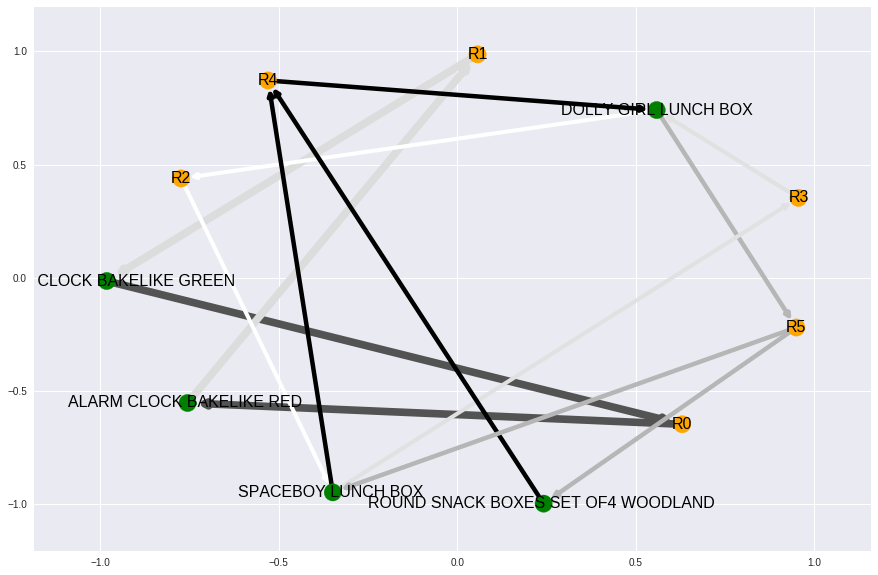

In [20]:
def analyze_country(country, min_support=0.10, lift_threshold=4):
  """Run associaton rule analysis for a given country."""
  transactions_per_row = df[df['Country'] == country].pivot_table(
      index='InvoiceNo', columns='Description', values='Quantity',
      aggfunc='sum', fill_value=0)
  # Let's get rid of postage, it's not really a product
  transactions_per_row.drop('POSTAGE', inplace=True, axis=1)
  # Last bit of cleaning - we only care if a transaction includes an item or not
  purchase_sets = transactions_per_row.applymap(
      lambda quantity: 1 if quantity >= 1 else 0)
  # Time for Apriori!
  # Calculate support (indication of how frequently itemset appears in data)
  # and confidence (indication of how often a rule is true)
  frequent_itemsets = apriori(purchase_sets, min_support=min_support,
                              use_colnames=True)
  associationrules = association_rules(frequent_itemsets, metric='lift',
                                       min_threshold=lift_threshold)
  print (associationrules)
  draw_association_graph(associationrules, associationrules.shape[0])
  

analyze_country('Belgium', min_support=0.08)

                             antecedants  \
0     (PLASTERS IN TIN WOODLAND ANIMALS)   
1       (PLASTERS IN TIN CIRCUS PARADE )   
2  (ROUND SNACK BOXES SET OF4 WOODLAND )   
3   (ROUND SNACK BOXES SET OF 4 FRUITS )   

                             consequents  antecedent support  \
0       (PLASTERS IN TIN CIRCUS PARADE )            0.104478   
1     (PLASTERS IN TIN WOODLAND ANIMALS)            0.087894   
2   (ROUND SNACK BOXES SET OF 4 FRUITS )            0.185738   
3  (ROUND SNACK BOXES SET OF4 WOODLAND )            0.119403   

   consequent support   support  confidence      lift  leverage  conviction  
0            0.087894  0.051410    0.492063  5.598383  0.042227    1.795709  
1            0.104478  0.051410    0.584906  5.598383  0.042227    2.157395  
2            0.119403  0.099502    0.535714  4.486607  0.077325    1.896670  
3            0.185738  0.099502    0.833333  4.486607  0.077325    4.885572  
Nodes: ['R0', 'PLASTERS IN TIN WOODLAND ANIMALS', 'PLASTERS IN TIN C

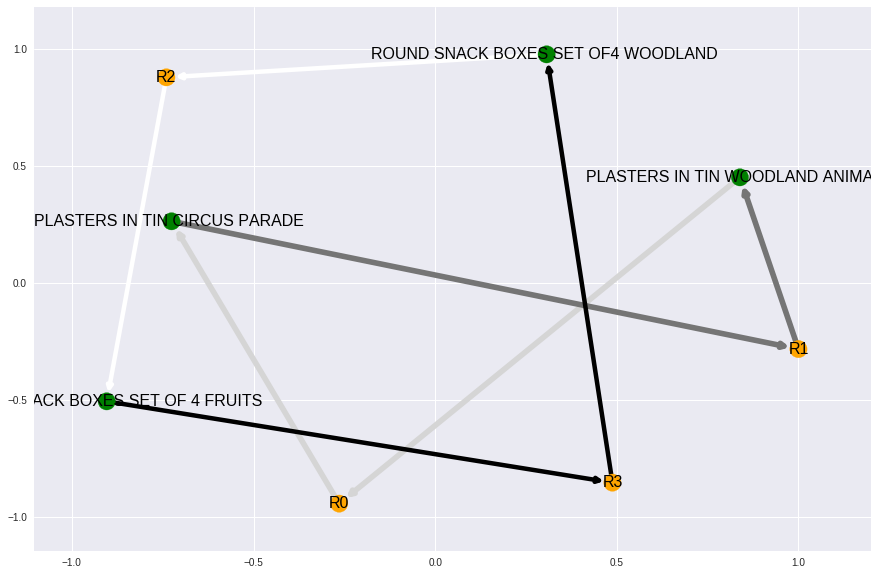

In [16]:
analyze_country('Germany', min_support=0.05)